### Clouds : Ana nodes from clouds with NEXT MC Beersheba events

J. A Hernando, M. Pérez

January 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import clouds.clouds    as clouds
import clouds.graphs    as graphs
import clouds.pltclouds as pltclouds

import clouds.mc_clouds as mcclouds

import invisible_cities.io.dst_io as dio

In [4]:
from utils.plotting_utils import plot_cloud_voxels, plot_cloud_voxels_and_hits, plot_3d_hits

In [5]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu Jan 20 21:14:59 2022


In [6]:
#import os
import re
import glob

In [7]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/"
filenames = ("Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5", 
             "Tl208_NEW_v1_03_01_nexus_v5_03_04_cut25.beersheba_label_4mm_fid.h5")
filenames = [datadir+file for file in filenames]
print('total files', len(filenames))
print(filenames[0])

total files 2
/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5


In [8]:
def get_dfs(filename):
    
    dfs = {}
    
    dfs['rcvoxels'] = dio.load_dst(filename, 'DATASET', 'BeershebaVoxels')
    dfs['mcvoxels'] = dio.load_dst(filename, 'DATASET', 'MCVoxels')
    dfs['mchits']   = dio.load_dst(filename, 'DATASET', 'MCHits')
    dfs['events']   = dio.load_dst(filename, 'DATASET', 'EventsInfo')
    dfs['bins']     = dio.load_dst(filename, 'DATASET', 'BinsInfo')
    
    return dfs

In [9]:
dfs = get_dfs(filenames[0])

In [10]:
rcvoxels   = dfs['rcvoxels']
mchits     = dfs['mchits']
voxel_size = [float(dfs['bins'][var].unique()) for var in ('size_x', 'size_y', 'size_z')]
print(voxel_size)

[5.0, 5.0, 4.0]


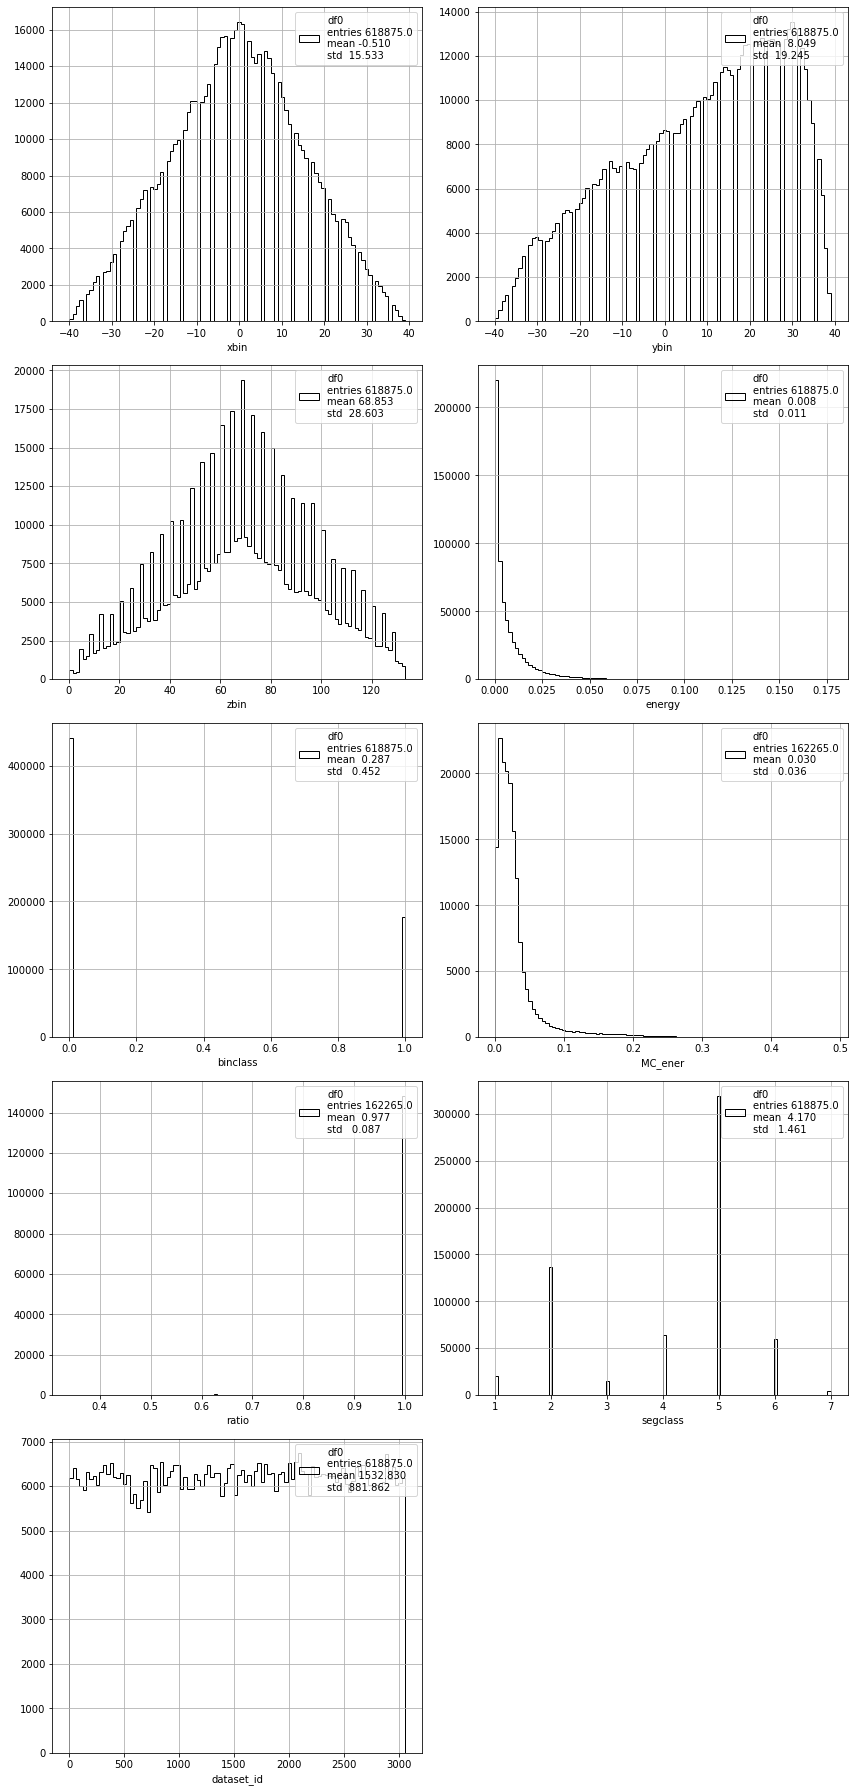

In [11]:
pltext.df_inspect(rcvoxels)

## Run: 

make clouds
ana nodes, are blobs? compute properties of nodes
return df


In [20]:
### Run over the events in the file
def run(rcvoxels, voxel_size, nevents = -1):

    seg_blob = 3
    
    events = rcvoxels['dataset_id'].unique()
    df     = None 
    nevents = len(events) if nevents == -1 else nevents
    print('events to process ', nevents)
    for evt in events[:nevents]:
        
        evoxels    = rcvoxels[rcvoxels.dataset_id == evt]
        ehits      = mchits  [mchits  .dataset_id == evt]
        edataclass = int(evoxels.binclass.unique())
        if (evt%100 == 0):
            print('Event :', evt, ', class : ', edataclass)
    
        coors  = [evoxels[var].values for var in ('xbin', 'ybin', 'zbin')]
        coors  = [size * coor for size, coor in zip(voxel_size, coors)]
        ene    = evoxels['energy'].values
        bins, mask, cells, cloud = clouds.clouds(coors, voxel_size, ene)
        cloud['segclass'] = evoxels['segclass'].values
    
        rsel = np.logical_or((cloud['eisridge'] == True), (cloud['eisnode'] == True))
        tsel = cloud['segclass'] <= 3
        
        rcom = rsel & tsel
        
        eff = float(np.sum(rcom)/np.sum(tsel))
        pur = float(np.sum(rcom)/np.sum(rsel))
        
        _df = pd.DataFrame()
        _df['dataset_id'] = [evt,]
        _df['dataclass']  = [edataclass,]
        _df['vtrack']     = [np.sum(rsel),]
        _df['vtrue']      = [np.sum(tsel),]
        _df['vcommon']    = [np.sum(rcom),]
        _df['eff']        = [eff,]
        _df['pur']        = [pur,]
        
        df = _df if df is None else pd.concat((df, _df), ignore_index = True)
    
    return df

In [23]:
df = run(rcvoxels, voxel_size, -1)

events to process  3059
Event : 0 , class :  0
Event : 100 , class :  1
Event : 200 , class :  0
Event : 300 , class :  0
Event : 400 , class :  0
Event : 500 , class :  1
Event : 600 , class :  1
Event : 700 , class :  0
Event : 800 , class :  0
Event : 900 , class :  0
Event : 1000 , class :  1
Event : 1100 , class :  0
Event : 1200 , class :  0
Event : 1300 , class :  0
Event : 1400 , class :  0
Event : 1500 , class :  0
Event : 1600 , class :  1
Event : 1700 , class :  1
Event : 1800 , class :  0
Event : 1900 , class :  0
Event : 2000 , class :  1
Event : 2100 , class :  0
Event : 2200 , class :  1
Event : 2300 , class :  0
Event : 2400 , class :  0
Event : 2500 , class :  0
Event : 2600 , class :  0
Event : 2700 , class :  1
Event : 2800 , class :  0
Event : 2900 , class :  0
Event : 3000 , class :  1


In [25]:
df

,dataset_id,dataclass,vtrack,vtrue,vcommon,eff,pur
0,0,0,24,46,17,0.369565,0.708333
1,1,0,35,70,28,0.400000,0.800000
2,2,0,25,46,20,0.434783,0.800000
3,3,0,20,35,13,0.371429,0.650000
4,4,0,24,59,18,0.305085,0.750000
...,...,...,...,...,...,...,...
3054,3054,1,21,52,17,0.326923,0.809524
3055,3055,0,30,66,25,0.378788,0.833333
3056,3056,0,37,77,30,0.389610,0.810811
3057,3057,0,30,63,20,0.317460,0.666667


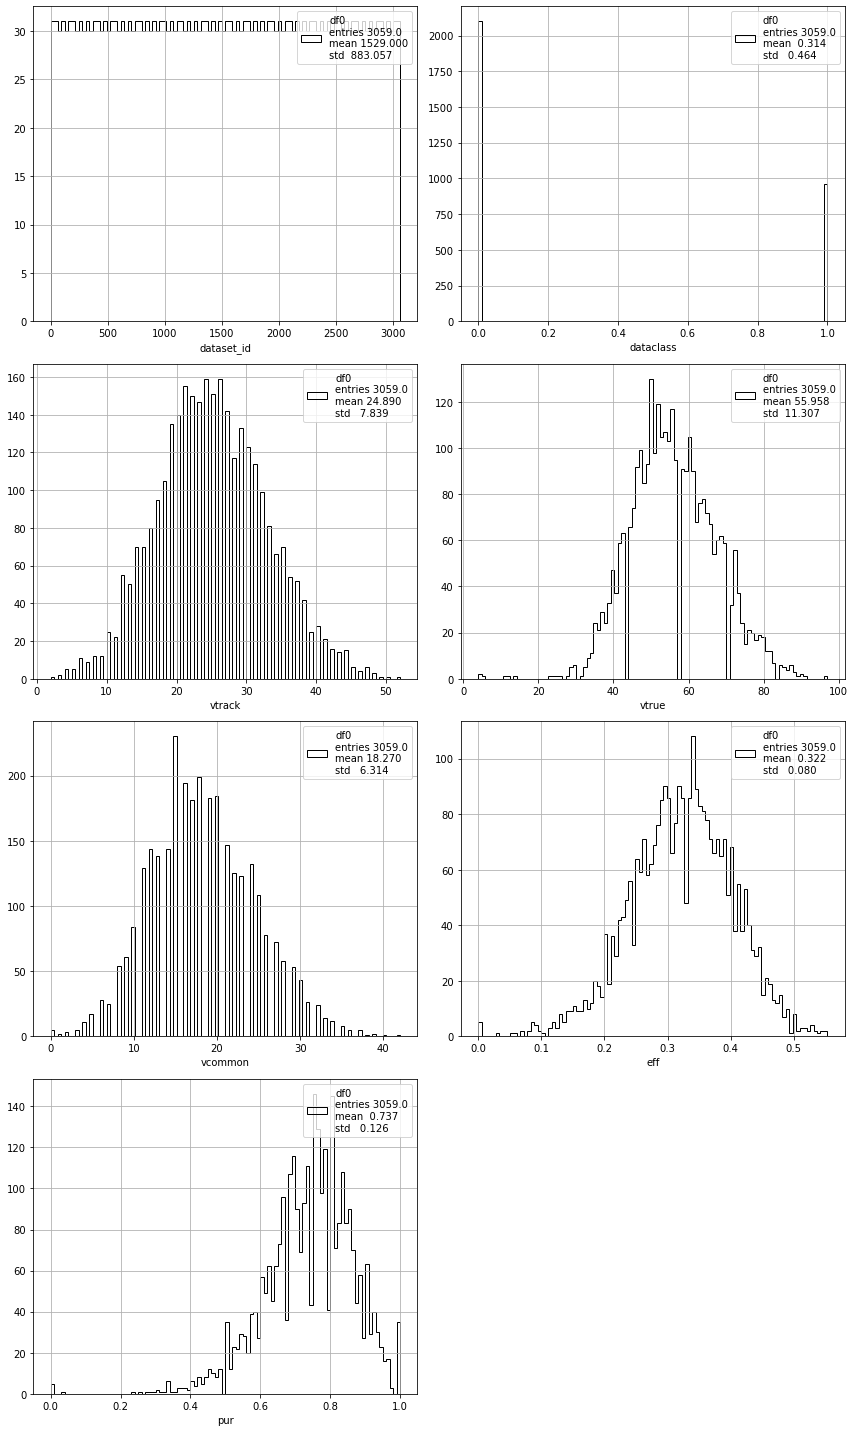

In [28]:
pltext.df_inspect(df)

<Figure size 504x432 with 0 Axes>

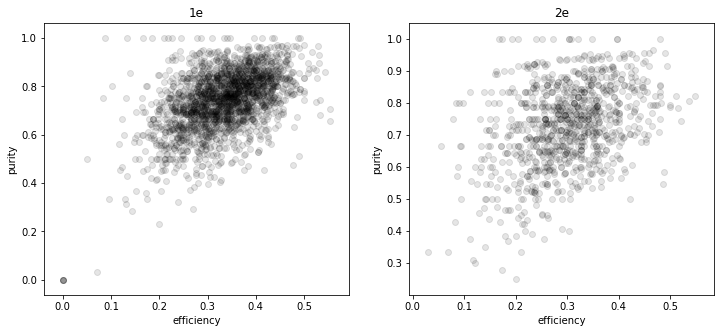

In [34]:
plt.figure(figsize = (7, 6));
cd = pltext.canvas(2, 2)
cd(1)
sel = df.dataclass == 0 
plt.title('1e')
plt.scatter(df.eff[sel], df.pur[sel], alpha = 0.1);
plt.xlabel('efficiency'); plt.ylabel('purity');
cd(2)
sel = df.dataclass == 1 
plt.title('2e')
plt.scatter(df.eff[sel], df.pur[sel], alpha = 0.1);
plt.xlabel('efficiency'); plt.ylabel('purity');

## Conclusions

   * En average purity is quite high 75 %, while efficiency is not 33 %
   
   * Why we have so low purity? [] Inspect some events and try to understand the low efficiency value!